# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

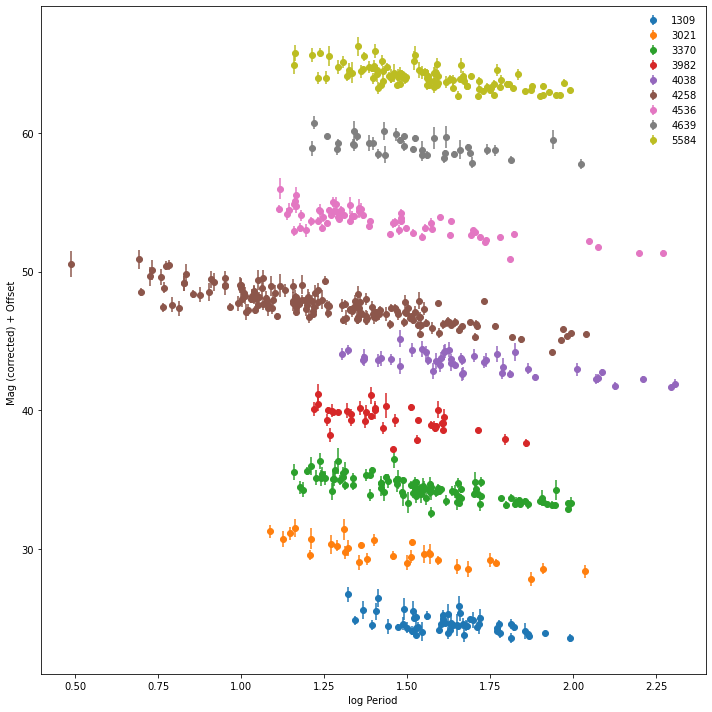

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

In [3]:
import emcee
import corner
from scipy.optimize import minimize
import astropy.constants as const
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


def set_mpl_style(fsize=15, tsize=18, tdir='in', major=5.0, minor=3.0, lwidth=1.8, lhandle=2.0):
    # Function to set MPL plotting style
    plt.style.use('default')
    plt.rcParams['text.usetex'] = False
    plt.rcParams["axes.axisbelow"] = False
    plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['ytick.right'] = True
    plt.rcParams['xtick.top'] = True
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = major
    plt.rcParams['ytick.minor.size'] = minor
    plt.rcParams['xtick.major.width'] = lwidth
    plt.rcParams['xtick.minor.width'] = lwidth
    plt.rcParams['ytick.major.width'] = lwidth
    plt.rcParams['ytick.minor.width'] = lwidth
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle
    return
set_mpl_style(major=8.0,minor=4.0,lwidth=1.2)

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


The magnitude model (removed metallicity):
$$m_{W,i,j}(logP_{i,j}, \theta) =(\mu_{0,i}-\mu_{0,4258})+zp_{W,4258}+b_W logP_{i,j}$$
where the parameters $\theta = (\mu_{0,i}-\mu_{0,4258}, zp_{W,4258},b_W)$.

The probability to observe $j$th Cepheid's magnitude in the $i$th host is: 
$$
p(logP_{i,j}, m_{i,j}, \sigma_{i,j}|\theta, m_{W,i,j}, \sigma_{\rm int}) = 
\frac{1}{\sqrt{2\pi(\sigma^2_{\rm int}+\sigma^2_{i,j})}}exp(
-\frac{(m_{i,j}-m_{W,i,j})^2}
{2(\sigma^2_{\rm int}+\sigma^2_{i,j})})
$$

The likelihood function:
$$
L = \prod_{i,j} \frac{1}{\sqrt{2\pi(\sigma^2_{\rm int}+\sigma^2_{i,j})}}exp(
-\frac{(m_{i,j}-m_{W,i,j})^2}
{2(\sigma^2_{\rm int}+\sigma^2_{i,j})})
$$

The log-likelihood function:
\begin{align}
ln L & = -\sum_{i,j}\frac{1}{2}ln(2\pi(\sigma^2_{\rm int}+\sigma^2_{i,j}))
-\sum_{i,j}\frac{(m_{i,j}-m_{W,i,j})^2}{2(\sigma^2_{\rm int}+\sigma^2_{i,j})}\\
& = -\sum_{i,j}\frac{1}{2}ln(2\pi(\sigma^2_{\rm int}+\sigma^2_{i,j}))
-\sum_{i,j}\frac{(m_{i,j}-((\mu_{0,i}-\mu_{0,4258})+zp_{W,4258}+b_W logP_{i,j}))^2}{2(\sigma^2_{\rm int}+\sigma^2_{i,j})}\\
\end{align}


# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

- ### $(\mu_{0,i}-\mu_{0,4258})+zp_{4258}$ (the intercept)
Based on defination: $\Delta\mu_{0, i}=\mu_{0,i}-\mu_{0,4258}=5log\frac{d_i}{d_{4258}}$ and the redshift of those galaxies, we can calculate the relative distance modulus. NGC4258 has the closest distance $d_{4258}\approx6.4$Mpc, and the other galaxies have distance $d_i\in(14, 35)$Mpc. So we firstly use the redshift to estimate inital priors $\Delta\mu_{0, z, i}\in(1.5, 3.5)$ and $zp_{4258}\approx29$ and then sample priors with normal distribution: $p(\mu_{0,i}-\mu_{0,4258}+zp_{4258}) = N(\Delta\mu_{0, z, i}+29, 0.5)$, where this intercept is constrained within (25, 35).

- ### $b_W$ (the slope) 
According to the period-luminosity relation, the slope of $m$ versus the $logP$ is around $-2.8$. So we sample priors with normal distribution: $p(b_W) = N(-2.8, 1)$, and $b_W$ is constrained within (-5, 0).

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [4]:
ndim = len(hosts)+1
nwalkers = 25
nburn = 5000
nsteps = 15000 
sigma_int = 0.08

In [5]:
def ceph_mag_model(logP_i, theta):
    # logP_i is the period of cepheids in one galaxy
    # generate the magnitude for cepheids in one galaxy 
    dmu_i, bw = theta
    return dmu_i+bw*logP_i

def log_likelihood(theta, sigma_int, ceph_data):
    # log likelihood function
    dmu_i_arr = theta[:len(hosts)]
    bw = theta[-1]
    logL = np.array([ ], dtype='f')
    # loop over each host galaxy
    for i, ID in enumerate(hosts):
        theta_i = np.array([dmu_i_arr[i], bw])
        ceph_data.select(ID)
        logP_i = ceph_data.logP
        m_obs = ceph_data.mobs
        m_obs_err = ceph_data.sigma
        model = ceph_mag_model(logP_i, theta_i)
        sigma2_all = m_obs_err**2+sigma_int**2
        logL = np.append(logL, -(m_obs-model)**2/sigma2_all/2. - np.log(2*np.pi*sigma2_all)/2.)
    return np.sum(logL)

In [6]:
def log_prior(theta):
    # prior
    dmu_i_arr = theta[:len(hosts)]
    bw = theta[-1]
    if all(dmu_i_arr<35.) and all(dmu_i_arr>25.) and (-5<bw<0):
        return 0.
    return -np.inf

def log_posterior(theta, ceph_data, sigma_int):
    # posterior
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf    
    return lp + log_likelihood(theta, sigma_int, ceph_data)

In [7]:
z_arr = np.array([0.007125, 0.005140, 0.004266, 0.003699, 0.005477, 0.001494, 0.006031, 0.003395, 0.005464])
dmu_arr = 5*np.log10(cosmo.luminosity_distance(z_arr)/cosmo.luminosity_distance(0.001494))

In [8]:
initial_geuss = np.append(dmu_arr, -2.8)
# MCMC sampling
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :len(hosts)] = np.random.normal(initial_geuss[:len(hosts)]+29, .5, (nwalkers,len(hosts)) ) # dmu_i+zp
starting_guesses[:, len(hosts)] = np.random.normal(initial_geuss[-1], 1, nwalkers) # bw

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[ceph, sigma_int])
_ = sampler.run_mcmc(starting_guesses, nsteps, progress=True)    

100%|██████████| 15000/15000 [03:59<00:00, 62.56it/s]


In [9]:
params_label = np.array([r'$\mu_{0, 1}-\mu_{0, 4258}$', r'$\mu_{0, 2}-\mu_{0, 4258}$', \
                         r'$\mu_{0, 3}-\mu_{0, 4258}$', r'$\mu_{0, 4}-\mu_{0, 4258}$', \
                         r'$\mu_{0, 5}-\mu_{0, 4258}$', r'$\mu_{0, 6}-\mu_{0, 4258}$', \
                         r'$\mu_{0, 7}-\mu_{0, 4258}$', r'$\mu_{0, 8}-\mu_{0, 4258}$', \
                         r'$\mu_{0, 9}-\mu_{0, 4258}$', r'$b_W$'])
# correct zp4258 based on fitting results
samples = sampler.chain[:, nburn:, :].reshape(-1, ndim)
zp4258 = np.median(samples[:,5])
samples[:, :-1] = samples[:, :-1]-zp4258
params_values = np.median(samples, axis=0)

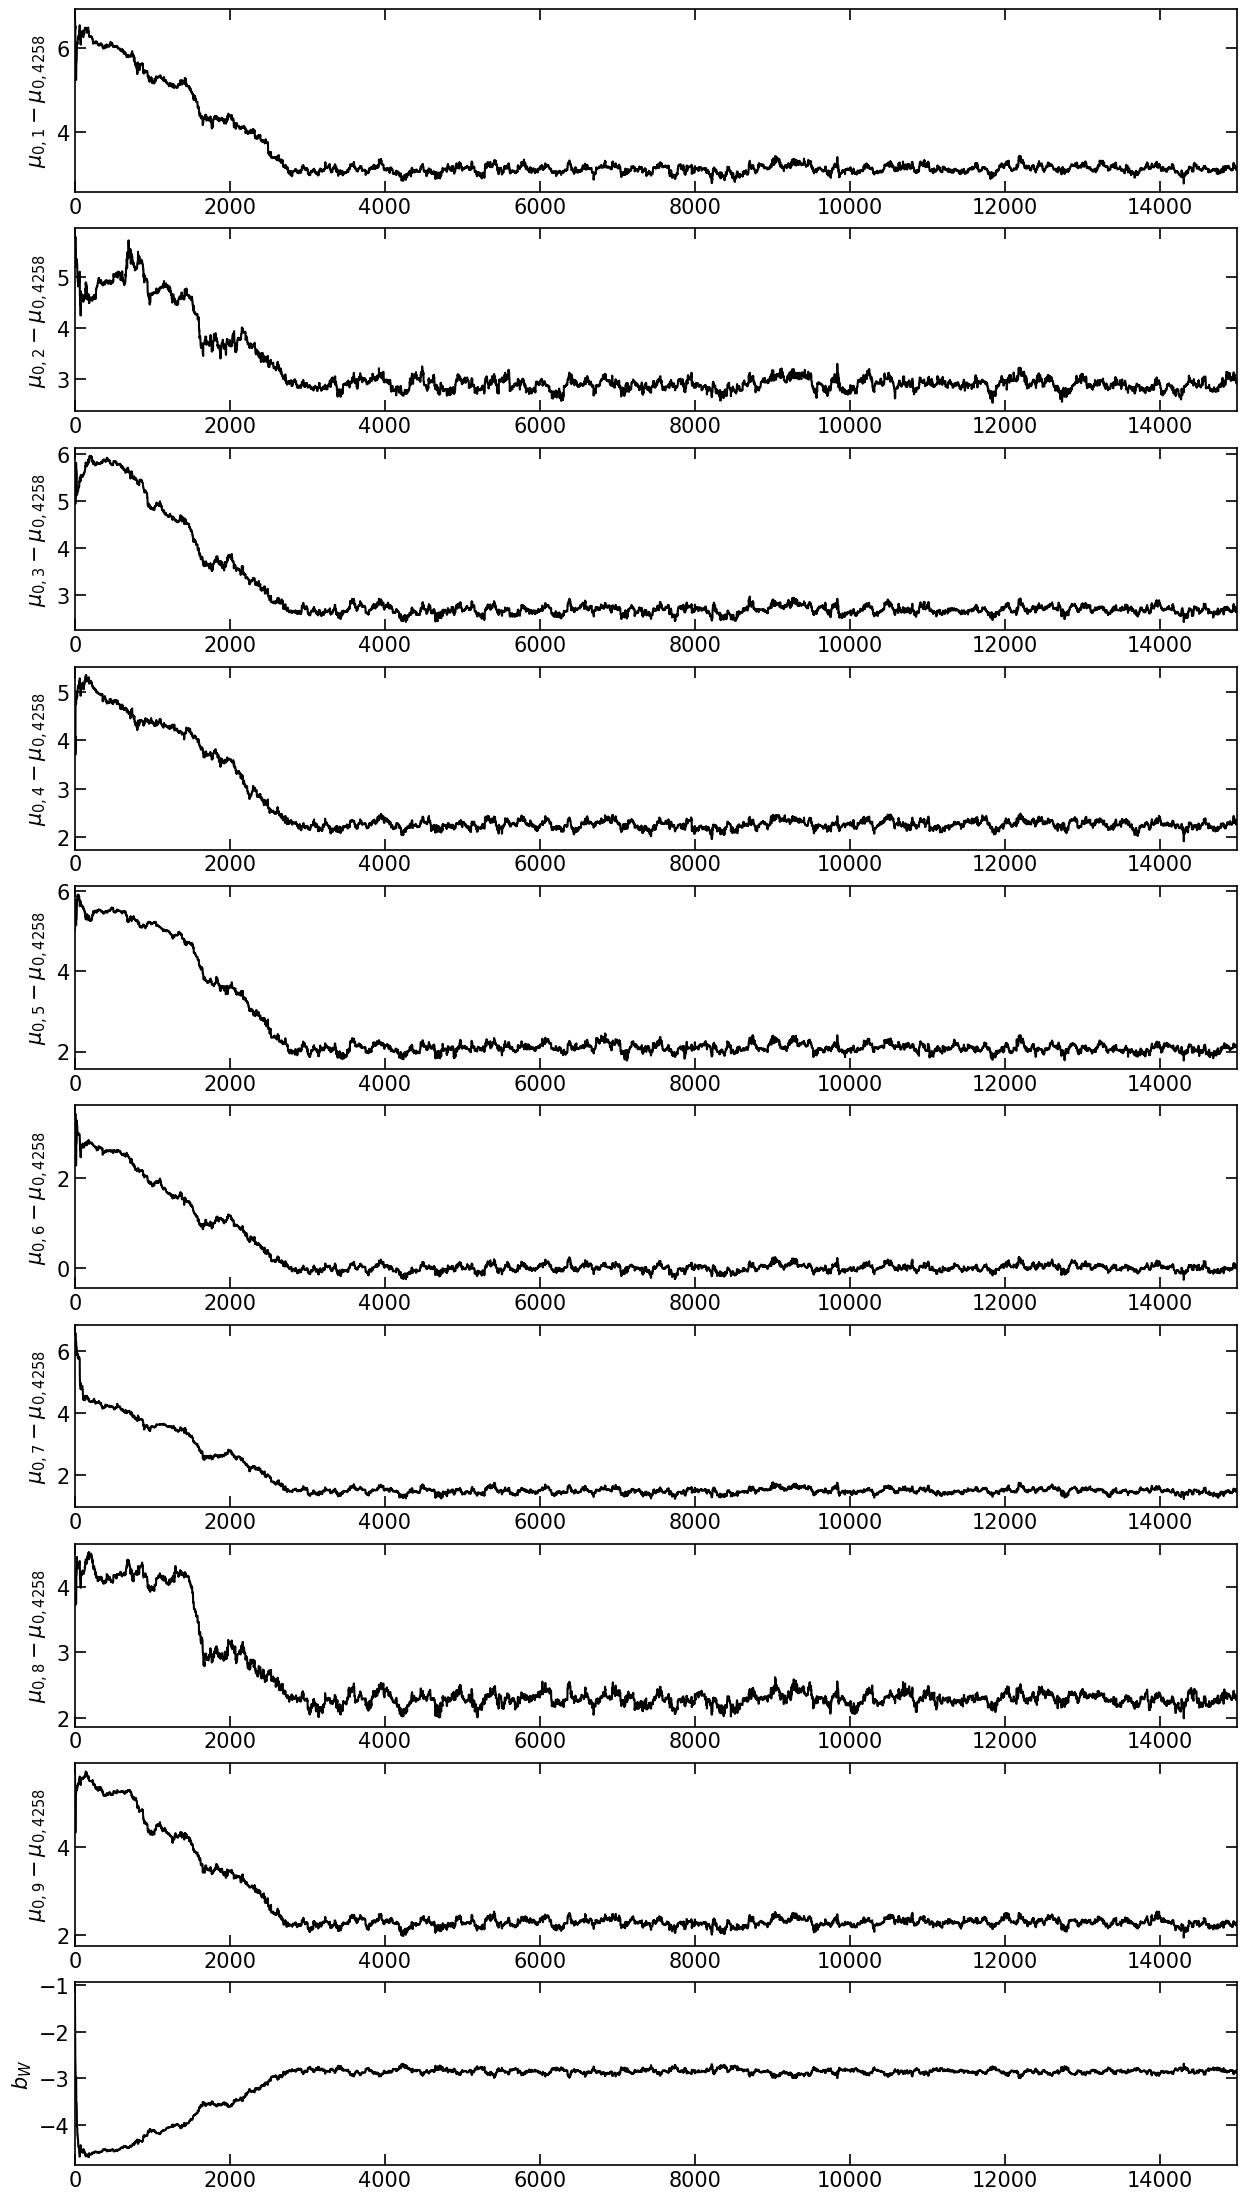

In [10]:
# trace plot
fig, axes = plt.subplots(10,1,figsize=(15, 28))
for p in range(10):
    if p != 9:
        axes[p].plot(sampler.chain[0,:,p]-zp4258, ls='-', c='k')
    else:
        axes[p].plot(sampler.chain[0,:,p], ls='-', c='k')
    axes[p].set_ylabel(params_label[p])
    axes[p].set_xlim(0, nsteps)

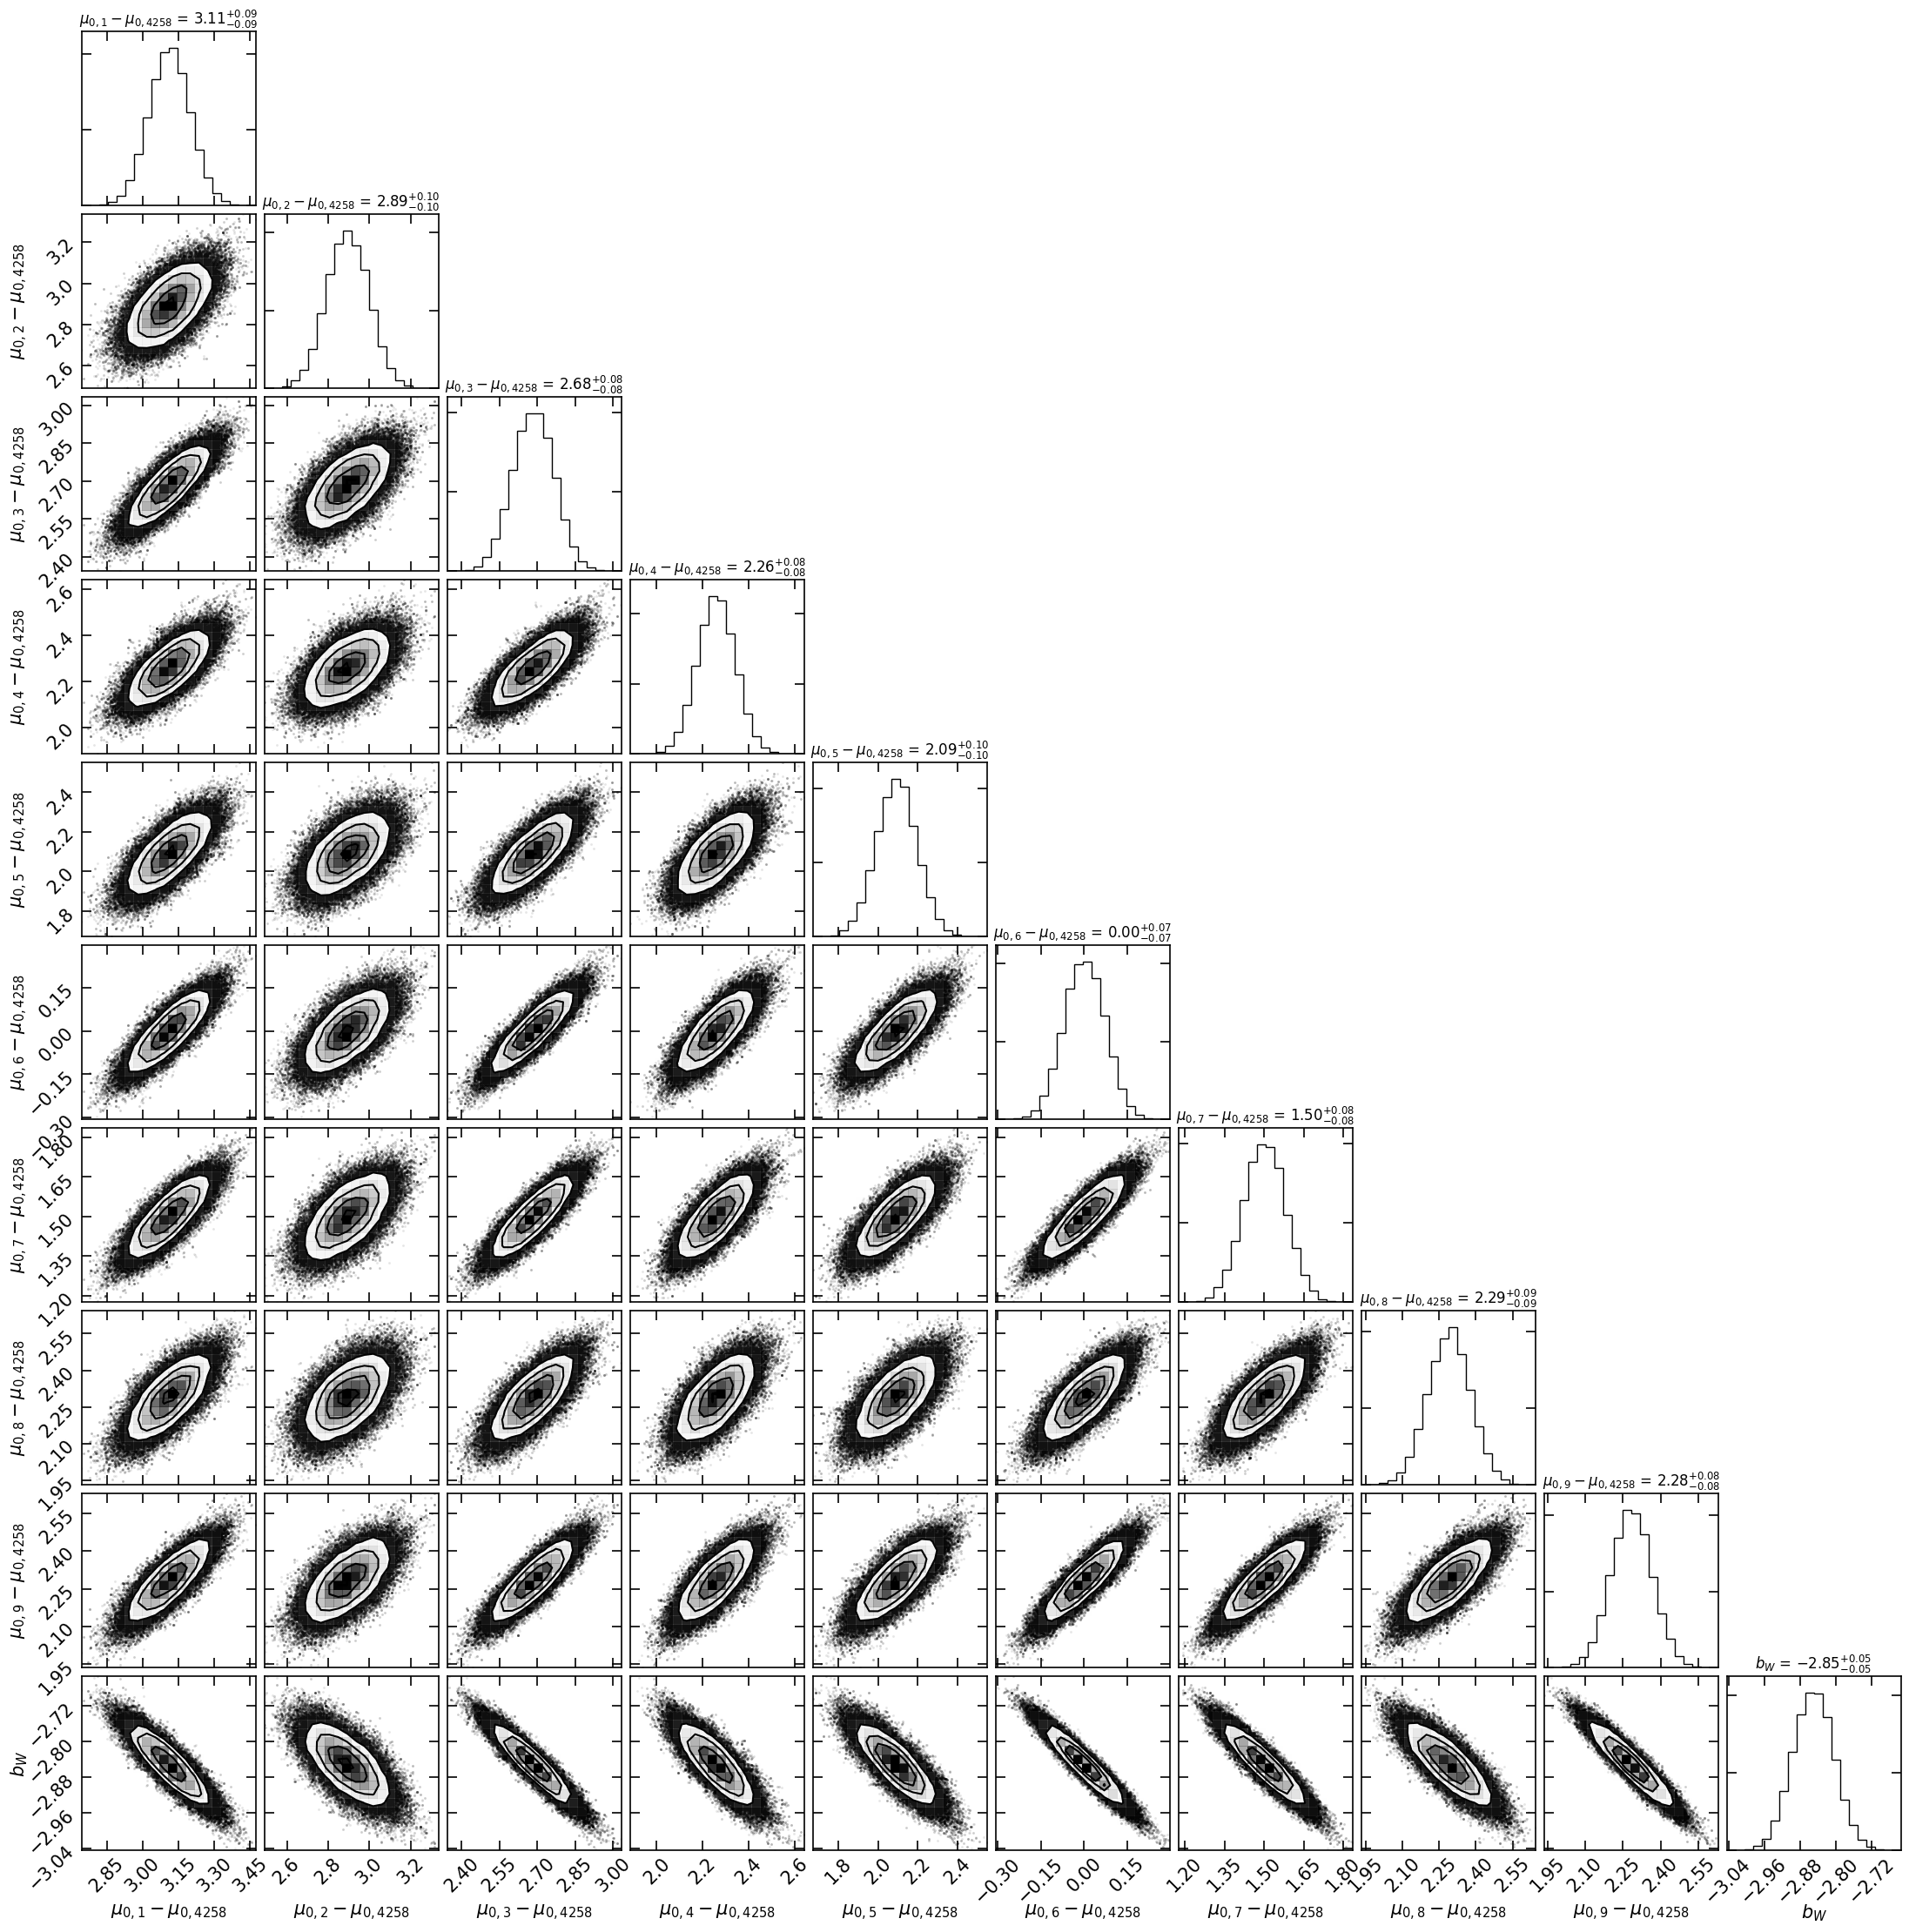

In [11]:
# corner plot
figure = corner.corner(samples, #quantiles=[0.16, 0.5, 0.84], \
                       show_titles=True, labels=params_label, title_kwargs={"fontsize": 12}, \
                       );

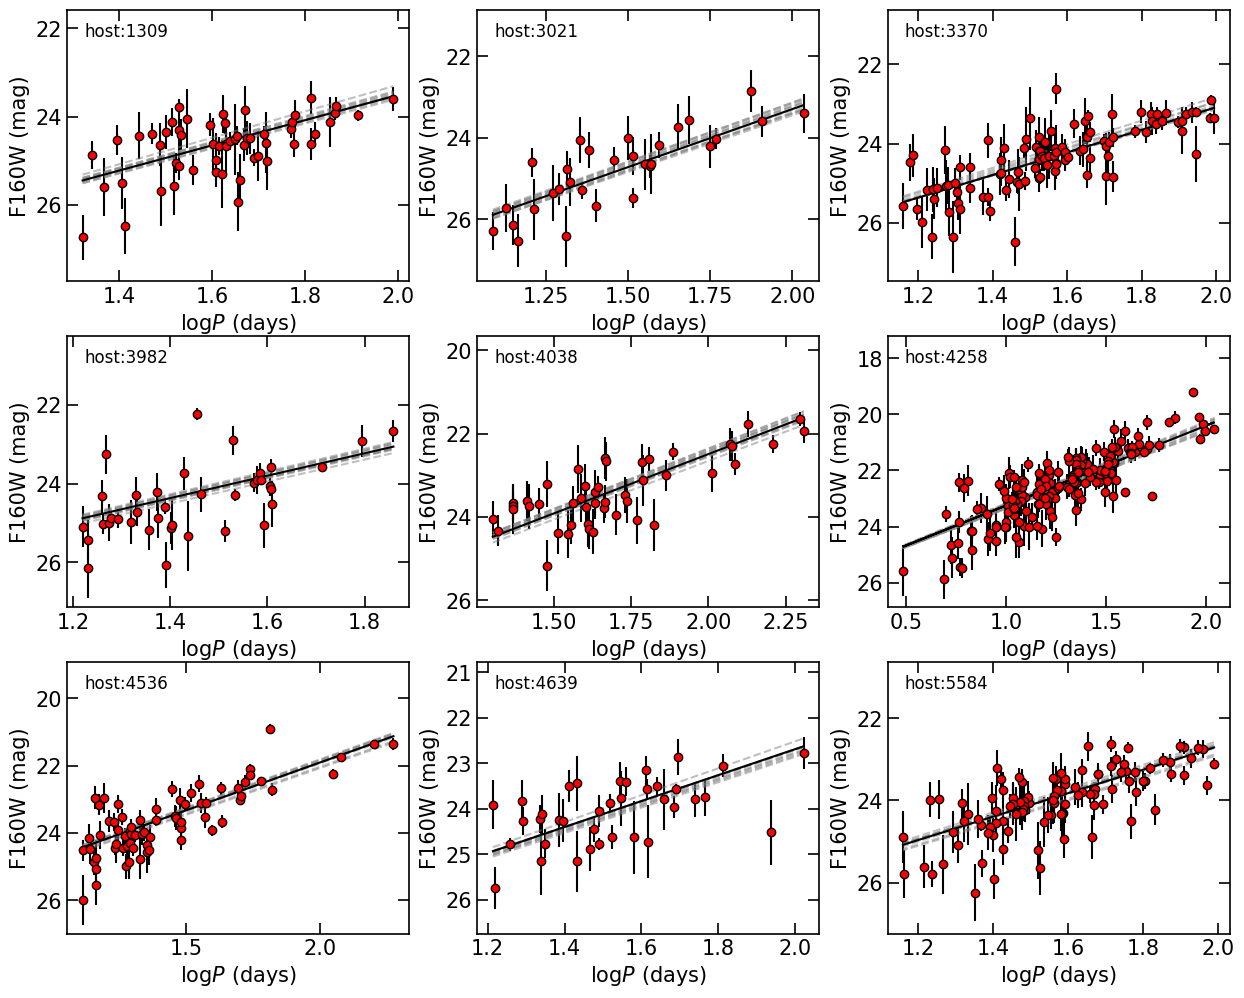

In [12]:
# regenerate Fig7
fig, axes = plt.subplots(3,3,figsize=(15, 12))
for i, ID in enumerate(hosts):
    ceph.select(ID)
    logP_i = ceph.logP
    m_obs = ceph.mobs
    m_obs_err = ceph.sigma
    axes[i//3][i%3].errorbar(logP_i, m_obs, yerr=m_obs_err, fmt='o', mec='k', mfc='r', ecolor='k')
    for r in range(10):
        pairs = samples[np.random.choice(len(samples)), :]
        axes[i//3][i%3].plot(logP_i, pairs[-1]*logP_i+pairs[i]+zp4258-pairs[5], c='grey', ls='--', alpha=0.5)
    axes[i//3][i%3].plot(logP_i, params_values[-1]*logP_i+params_values[i]+zp4258, \
                         c='k', ls='-')
    axes[i//3][i%3].set_ylim(m_obs.max()+1, m_obs.min()-2)
    axes[i//3][i%3].text(0.05, 0.9, 'host:'+ID, fontsize=12, transform=axes[i//3][i%3].transAxes)
    axes[i//3][i%3].set_ylabel(r'F160W (mag)')
    axes[i//3][i%3].set_xlabel(r'log$P$ (days)')

In [13]:
# load table3
table3_host = np.array(['4536', '4639', '3370', '3982', '3021', '1309', '5584', '4038'], dtype='<U21')
table3_dmu = np.array([1.567, 2.383, 2.835, 2.475, 3.138, 3.276, 2.461, 2.396])
tb3_found, hosts_ind, tb3_ind = np.intersect1d(hosts, table3_host, return_indices=True)

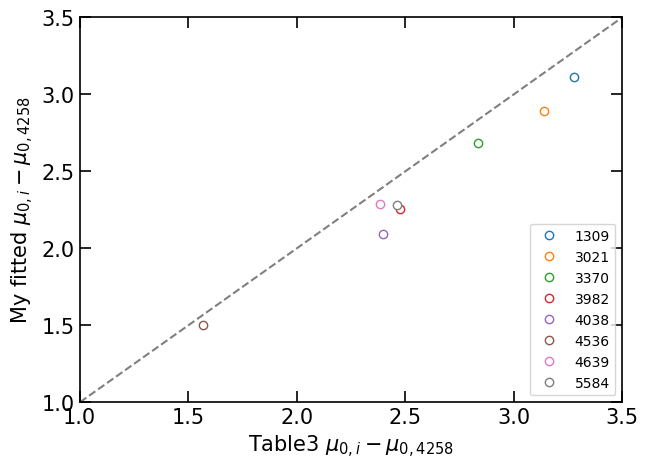

In [16]:
# comapre relative distance modulus with table 3
fig, axes = plt.subplots(1, 1,figsize=(7, 5))
for i in range(len(tb3_found)):
    axes.plot(table3_dmu[tb3_ind][i], params_values[hosts_ind][i], \
              mfc='w',ls='', marker='o', label=tb3_found[i])
axes.plot([0, 5], [0, 5], ls='--', c='grey', zorder=-1)
axes.set_xlim(1,3.5)
axes.set_ylim(1,3.5)
axes.set_xlabel(r'Table3 $\mu_{0, i}-\mu_{0, 4258}$')
axes.set_ylabel(r'My fitted $\mu_{0, i}-\mu_{0, 4258}$')
axes.legend(loc='lower right', fontsize=10)

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

Equation 3 can be written as: $$m^0_{v, 4258}-\mu_{0, 4258} = m^0_{v, i}-\mu_{0, i}$$

subsitute into equation 4:
\begin{align}
log H_0 & = \frac{(m^0_{v, 4258}-\mu_{0, 4258})+5a_v+25}{5}\\
& = \frac{(m^0_{v, i}-\mu_{0, i})+5a_v+25}{5}\\
& = \frac{(m^0_{v, i}+5a_v)-(\mu_{0, i}-\mu_{0, 4258})-\mu_{0, 4258}+25}{5}\\
\end{align}

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [23]:
d_4258 = 7.6*u.Mpc
mu_4258 = 5*np.log10((d_4258/10/u.pc).cgs.value)

In [24]:
table3_m0_5av = np.array([15.147, 16.040, 16.545, 15.953, 16.699, 16.768, 16.274, 15.901])
logH_arr = (table3_m0_5av[tb3_ind]-params_values[hosts_ind]-mu_4258+25)/5
H_arr = 10**logH_arr
print(H_arr)

[70.8845851  75.91740281 77.9230062  72.15390233 76.06050977 70.54713554
 74.00070192 82.71456619]


In [25]:
print('The estimated Hubble constant is H0=%.3f'%np.mean(H_arr))

The estimated Hubble constant is H0=75.025
